In [ ]:
# Drive Mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install timm

In [ ]:
import os
import sys
import time
import random
import timm
import argparse

from collections import OrderedDict
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from IPython.display import clear_output

# working with images
import cv2
import imageio
import scipy.ndimage
# import skimage.transform

import torchvision.transforms as transforms

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# import torchsummary
from tqdm import notebook

sys.path.insert(0, '..')

# losses
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss, DiceBCELoss , dice_pytorch_eval
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test

# dataset
from utils.dataset import myDataSet,Test_Detection
from utils.create_data import create_dataset,create_detection_dataset

# models
from utils.create_model import create_model

# train
from utils.train import fit, metric

# 데이터 시각화

In [ ]:
data_name = 'image_segmentation'
BATCH_SIZE = 8

# dataset
custom_dataset_train, custom_dataset_val, custom_dataset_test = create_dataset(data_name = data_name)

# dataloader
dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(custom_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
dataloader_test = torch.utils.data.DataLoader(custom_dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

## Dataset 시각화

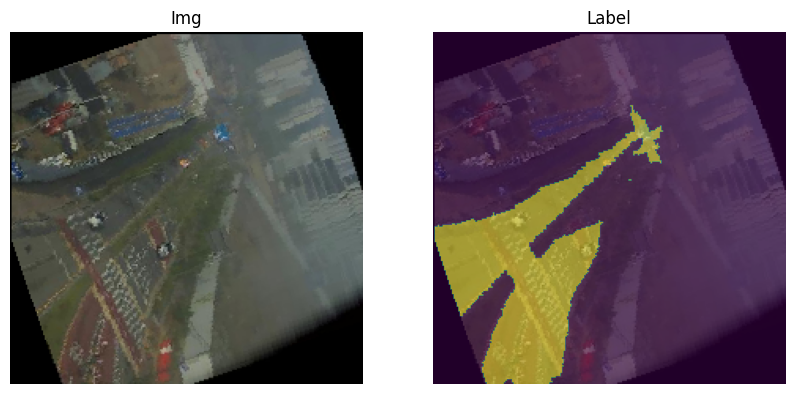

In [ ]:
img,mask = custom_dataset_train[10]

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Img')
plt.axis('off')
plt.imshow(img.permute(1,2,0))

plt.subplot(1,2,2)
plt.title('Label')
plt.axis('off')
plt.imshow(img.permute(1,2,0))
plt.imshow(mask.permute(1,2,0),alpha=0.5)

## Dataloader 시각화

In [ ]:
for batch in dataloader_test:
  for img,mask in zip(batch[0],batch[1]):
    img = img.permute(1,2,0)
    mask = mask.permute(1,2,0)
    mask_colored = np.where(mask == 1, [255,255,255], [0,0,0]) # 도로

    plt.imshow(img)
    plt.imshow(mask_colored,alpha=0.5)

    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def torch_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
def run(model_name):
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu

    """
    args(model)
        unet,
        fcbformer,
        deeplab_v3_p,
        fft_deeplab_v3_p


    args(data name)
        image_segmentation
    """

    # torch_seed(random_seed = args.seed)
    epochs = 100
    patience = 20
    BATCH_SIZE = 8

    # model_name = 'fft_deeplab_v3_p'
    data_name = 'image_segmentation'

    # model
    model = create_model(model_name = model_name).to(DEVICE)

    # dataset
    custom_dataset_train, custom_dataset_val, custom_dataset_test = create_dataset(data_name = data_name)

    # dataloader
    dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    dataloader_val = torch.utils.data.DataLoader(custom_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    dataloader_test = torch.utils.data.DataLoader(custom_dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    # set training
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)
    criterion = DiceBCELoss()


    fit(model=model,
        dataloader_train=dataloader_train,
        dataloader_val=dataloader_val,
        criterion=criterion,
        optimizer=optimizer,
        DEVICE=DEVICE,
        epochs=epochs,
        model_name=model_name,
        data_name=data_name,
        patience=patience)


    # fit 함수가 종료된 후, 테스트 데이터에 대해 평가를 진행
    metric(model = model,
           dataloader_test = dataloader_test,
           DEVICE = DEVICE,
           model_name = model_name,
           criterion = criterion,
           data_name = data_name)

    print('Test completed!')

In [ ]:
run(model_name = 'fcbformer')  # 학습 미완료, earlystopping: 27epoch, dice: 0.814999, IoU: 0.703092

/content/drive/MyDrive/sejong/segmentation/models/pvt_v2.py:332: UserWarning: Overwriting pvt_v2_b0 in registry with models.pvt_v2.pvt_v2_b0. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def pvt_v2_b0(pretrained=False, **kwargs):
/content/drive/MyDrive/sejong/segmentation/models/pvt_v2.py:343: UserWarning: Overwriting pvt_v2_b1 in registry with models.pvt_v2.pvt_v2_b1. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def pvt_v2_b1(pretrained=False, **kwargs):
/content/drive/MyDrive/sejong/segmentation/models/pvt_v2.py:354: UserWarning: Overwriting pvt_v2_b2 in registry with models.pvt_v2.pvt_v2_b2. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def pvt_v2_b2(pretrained=False, **kwargs):
/content/drive/MyDrive/sejong/segmentation/models/pvt_v2.py:364: UserWarning: Overwriting pvt_v2_b3 

Constructed FCBFormer model.


/content/drive/MyDrive/sejong/segmentation/models/FCBmodels.py:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("./models/pvt_v2_b3.pth")


epoch : 0
 Epoch: 0 of 100, Iter.: 139 of 139, Train Loss: 0.460155, IoU: 0.711544, Dice: 0.817777
 Epoch: 0 of 100, Iter.: 139 of 139, Valid Loss: 0.367205, IoU: 0.763508, Dice: 0.859840, FPS: 21.60
epoch : 1
 Epoch: 1 of 100, Iter.: 139 of 139, Train Loss: 0.222261, IoU: 0.834694, Dice: 0.905530
 Epoch: 1 of 100, Iter.: 139 of 139, Valid Loss: 0.316527, IoU: 0.803523, Dice: 0.886281, FPS: 21.29
epoch : 2
 Epoch: 2 of 100, Iter.: 139 of 139, Train Loss: 0.169681, IoU: 0.865899, Dice: 0.924273
 Epoch: 2 of 100, Iter.: 139 of 139, Valid Loss: 0.319996, IoU: 0.804860, Dice: 0.886979, FPS: 21.51
epoch : 3
 Epoch: 3 of 100, Iter.: 139 of 139, Train Loss: 0.144827, IoU: 0.883493, Dice: 0.935185
 Epoch: 3 of 100, Iter.: 139 of 139, Valid Loss: 0.291183, IoU: 0.819467, Dice: 0.895817, FPS: 21.22
epoch : 4
 Epoch: 4 of 100, Iter.: 139 of 139, Train Loss: 0.126439, IoU: 0.895488, Dice: 0.941903
 Epoch: 4 of 100, Iter.: 139 of 139, Valid Loss: 0.293298, IoU: 0.824711, Dice: 0.899419, FPS: 21.45


/content/drive/MyDrive/sejong/segmentation/utils/train.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=DE

 Test Loss: 0.588605, IoU: 0.703092, Dice: 0.814999, FPS(gpu): 22.70, FPS(cpu): 1.47
Test results saved in /content/drive/MyDrive/sejong/segmentation/checkpoints/fcbformer/results_fcbformer_image_segmentation.csv
Test completed!


In [ ]:
run(model_name = 'unet')  # 학습 완료, earlystopping: 55epoch, dice: 0.72638 , IoU: 0.614666

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Constructed UNet model.
epoch : 0
 Epoch: 0 of 100, Iter.: 139 of 139, Train Loss: 0.638844, IoU: 0.660623, Dice: 0.776875
 Epoch: 0 of 100, Iter.: 139 of 139, Valid Loss: 0.625693, IoU: 0.671390, Dice: 0.795106, FPS: 44.82
epoch : 1
 Epoch: 1 of 100, Iter.: 139 of 139, Train Loss: 0.425858, IoU: 0.769400, Dice: 0.861652
 Epoch: 1 of 100, Iter.: 139 of 139, Valid Loss: 0.492979, IoU: 0.725362, Dice: 0.827841, FPS: 48.81
epoch : 2
 Epoch: 2 of 100, Iter.: 139 of 139, Train Loss: 0.345694, IoU: 0.804155, Dice: 0.884050
 Epoch: 2 of 100, Iter.: 139 of 139, Valid Loss: 0.491858, IoU: 0.729598, Dice: 0.834428, FPS: 47.87
epoch : 3
 Epoch: 3 of 100, Iter.: 139 of 139, Train Loss: 0.290990, IoU: 0.827309, Dice: 0.898539
 Epoch: 3 of 100, Iter.: 139 of 139, Valid Loss: 0.392549, IoU: 0.767809, Dice: 0.852685, FPS: 48.23
epoch : 4
 Epoch: 4 of 100, Iter.: 139 of 139, Train Loss: 0.258153, IoU: 0.836496, Dice: 0.903632
 Epoch: 4 of 100, Iter.: 139 of 139, Valid Loss: 0.468739, IoU: 0.736511, Dic

/content/drive/MyDrive/sejong/segmentation/utils/train.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=DE

 Test Loss: 0.920464, IoU: 0.614666, Dice: 0.726380, FPS(gpu): 47.37, FPS(cpu): 1.24
Test results saved in /content/drive/MyDrive/sejong/segmentation/checkpoints/unet/results_unet_image_segmentation.csv
Test completed!


In [ ]:
run(model_name = 'deeplab_v3_p')  # 학습 미완료, earlystopping:

Constructed DeepLabv3+ model.


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:02<00:00, 88.9MB/s]


epoch : 0
 Epoch: 0 of 100, Iter.: 139 of 139, Train Loss: 0.523993, IoU: 0.679616, Dice: 0.793383
 Epoch: 0 of 100, Iter.: 139 of 139, Valid Loss: 0.586287, IoU: 0.624628, Dice: 0.740658, FPS: 44.66
epoch : 1
 Epoch: 1 of 100, Iter.: 139 of 139, Train Loss: 0.296651, IoU: 0.794304, Dice: 0.876599
 Epoch: 1 of 100, Iter.: 139 of 139, Valid Loss: 0.693903, IoU: 0.585815, Dice: 0.693123, FPS: 42.56
epoch : 2
 Epoch: 2 of 100, Iter.: 139 of 139, Train Loss: 0.234630, IoU: 0.829717, Dice: 0.900182
 Epoch: 2 of 100, Iter.: 139 of 139, Valid Loss: 0.465312, IoU: 0.707294, Dice: 0.806846, FPS: 43.76
epoch : 3
 Epoch: 3 of 100, Iter.: 139 of 139, Train Loss: 0.196420, IoU: 0.853452, Dice: 0.915134
 Epoch: 3 of 100, Iter.: 139 of 139, Valid Loss: 0.540665, IoU: 0.679105, Dice: 0.779347, FPS: 37.06
epoch : 4
 Epoch: 4 of 100, Iter.: 139 of 139, Train Loss: 0.174873, IoU: 0.863559, Dice: 0.920768
 Epoch: 4 of 100, Iter.: 139 of 139, Valid Loss: 0.435042, IoU: 0.723694, Dice: 0.823283, FPS: 37.97


/content/drive/MyDrive/sejong/segmentation/utils/train.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=DE

 Test Loss: 0.749418, IoU: 0.648695, Dice: 0.770655, FPS(gpu): 49.15, FPS(cpu): 0.63
Test results saved in /content/drive/MyDrive/sejong/segmentation/checkpoints/deeplab_v3_p/results_deeplab_v3_p_image_segmentation.csv
Test completed!


In [ ]:
run(model_name = 'fft_deeplab_v3_p')

Constructing FFT_DeepLabv3_plus model...
Number of classes: 1
Output stride: 16
Number of Input Channels: 3
epoch : 0
 Epoch: 0 of 100, Iter.: 139 of 139, Train Loss: 0.703081, IoU: 0.522685, Dice: 0.664660
 Epoch: 0 of 100, Iter.: 139 of 139, Valid Loss: 0.465387, IoU: 0.689978, Dice: 0.806579, FPS: 52.38
epoch : 1
 Epoch: 1 of 100, Iter.: 139 of 139, Train Loss: 0.528837, IoU: 0.576009, Dice: 0.713620
 Epoch: 1 of 100, Iter.: 139 of 139, Valid Loss: 0.416503, IoU: 0.700134, Dice: 0.813424, FPS: 58.36
epoch : 2
 Epoch: 2 of 100, Iter.: 139 of 139, Train Loss: 0.470289, IoU: 0.596231, Dice: 0.730025
 Epoch: 2 of 100, Iter.: 139 of 139, Valid Loss: 0.417402, IoU: 0.703202, Dice: 0.816632, FPS: 57.43
epoch : 3
 Epoch: 3 of 100, Iter.: 139 of 139, Train Loss: 0.454137, IoU: 0.603195, Dice: 0.736767
 Epoch: 3 of 100, Iter.: 139 of 139, Valid Loss: 0.386943, IoU: 0.711782, Dice: 0.822347, FPS: 60.03
epoch : 4
 Epoch: 4 of 100, Iter.: 139 of 139, Train Loss: 0.433016, IoU: 0.614748, Dice: 0.

/content/drive/MyDrive/sejong/segmentation/train.py:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=DEVICE)[

 Test Loss: 0.241387, IoU: 0.790671, Dice: 0.876615, FPS(gpu): 57.78, FPS(cpu): 4.23
Test results saved in /content/drive/MyDrive/sejong/segmentation/checkpoints/fft_deeplab_v3_p/results_fft_deeplab_v3_p_image_segmentation.csv
Test completed!


# Test 이미지 시각화

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu

data_name = 'image_segmentation'
# model_name = 'fft_deeplab_v3_p'

# model
model = create_model(model_name = model_name)
checkpoint_path = f'./segmentation/checkpoints/{model_name}/ckpt_{model_name}_{data_name}.pth'

model.load_state_dict(torch.load(checkpoint_path, map_location=DEVICE)['net'])

# dataset
custom_dataset_train, custom_dataset_val, custom_dataset_test = create_dataset(data_name = data_name)

# dataloader
dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=1, shuffle=True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(custom_dataset_val, batch_size=1, shuffle=False, num_workers=2)
dataloader_test = torch.utils.data.DataLoader(custom_dataset_test, batch_size=1, shuffle=False, num_workers=2)


model.eval()
with torch.no_grad():
    for batch, data in enumerate(dataloader_test):
        imgs = data[0].to(DEVICE)
        masks = data[1].to(DEVICE)  # (8,3,224,224), (8,1,224,224)

        model.to(DEVICE)
        predictions = model(imgs)
        predictions = predictions.data.cpu().numpy()
        predictions = predictions.squeeze(0).transpose(1,2,0)
        predictions = (predictions - np.min(predictions)) / (np.max(predictions) - np.min(predictions))
        predictions = (predictions > 0.5).astype(np.uint8)

        kernel_size = (5, 5)
        sigma = 1.5
        smooth_pred = cv2.GaussianBlur(predictions, kernel_size, sigma)

        mask_colored = np.where(smooth_pred > 0.5, np.ones_like(smooth_pred) * 255, np.zeros_like(smooth_pred))
        mask_colored_rgb = np.stack([mask_colored] * 3, axis=-1)

        masks = masks.data.cpu().numpy()
        masks = masks.squeeze(0).transpose(1, 2, 0)

        imgs = imgs.data.cpu().numpy()
        imgs = imgs.squeeze().transpose(1, 2, 0)

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 4, 1)
        plt.title('Original')
        plt.axis('off')
        plt.imshow(imgs)

        plt.subplot(1, 4, 2)
        plt.title('Predict')
        plt.axis('off')
        plt.imshow(mask_colored_rgb, cmap='gray')

        plt.subplot(1, 4, 3)
        plt.title('Label')
        plt.axis('off')
        plt.imshow(masks, cmap='gray')

        plt.subplot(1, 4, 4)
        plt.title('Image - mask')
        plt.axis('off')
        plt.imshow(imgs-mask_colored_rgb+255) # 도로만 segmentation된 이미지

        plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Make Detection Trainset

In [ ]:
test_detection_img = create_detection_dataset(data_name = 'image_segmentation')
test_detection_dataloader = DataLoader(test_detection_img, batch_size=1 , shuffle=False)

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu

data_name = 'image_segmentation'
# model_name = 'fft_deeplab_v3_p'

# model
model = create_model(model_name = model_name)
checkpoint_path = f'./segmentation/checkpoints/{model_name}/ckpt_{model_name}_{data_name}.pth'

model.load_state_dict(torch.load(checkpoint_path, map_location=DEVICE)['net'])

model.eval()
with torch.no_grad():
    for batch, data in enumerate(test_detection_dataloader):
        imgs = data.to(DEVICE)

        model.to(DEVICE)

        predictions = model(imgs)
        predictions = predictions.data.cpu().numpy() # tensor -> array
        predictions = predictions.squeeze(0).transpose(1,2,0) # (B,C,H,W) -> (H,W,C)
        predictions = (predictions - np.min(predictions)) / (np.max(predictions) - np.min(predictions))
        predictions = (predictions > 0.5).astype(np.uint8)

        kernel_size = (3, 3)
        sigma = 1.5
        smooth_pred = cv2.GaussianBlur(predictions, kernel_size, sigma)

        mask_colored = np.where(smooth_pred > 0.5, np.ones_like(smooth_pred) * 255, np.zeros_like(smooth_pred))
        mask_colored_rgb = np.stack([mask_colored] * 3, axis=-1)  # channel 1 -> channel 3
        mask_colored_rgb = cv2.cvtColor(mask_colored_rgb,cv2.COLOR_BGR2RGB)
        # mask_colored_rgb = mask_colored_rgb.astype(np.uint8)

        imgs = imgs.data.cpu().numpy()  # tensor -> array
        imgs = imgs.squeeze().transpose(1,2,0)  # (B,C,H,W) -> (H,W,C)
        imgs = cv2.cvtColor(imgs,cv2.COLOR_BGR2RGB)  # (BGR -> RGB)
        imgs = imgs*255 # 0~1(float) -> 0~255(int)

        cv2_imshow(imgs-mask_colored_rgb+255)

        cv2.imwrite(f'./segmentation/data/segmented_images/{batch}.jpg',imgs-mask_colored_rgb+255)

Output hidden; open in https://colab.research.google.com to view.